In [5]:
from fidelity_analysis.utils import setup_plotting
import time
import os

import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm

from floquet_analysis.transmon_floquet_simulator import TransmonFloquetSimulator
from floquet_analysis.transmon_resonator_fitter import TransmonResonatorFitter
from joblib import Parallel, delayed

setup_plotting()

In [6]:
current_path = os.path.abspath("")
data_dir_path = os.path.join(current_path, "data")
images_dir_path = os.path.join(current_path, "images")

In [7]:
# Measured frequencies
f01_meas = 3.845965050
f12_meas = 3.602264855

fr0_meas = 6.065852884
fr1_meas = 6.064931745
fr2_meas = 6.064094073

kappa_div2pi = 0.55 * 1e-3  #GHz

fitter = TransmonResonatorFitter(f01_meas, f12_meas, fr0_meas, fr1_meas, fr2_meas)

EJ_fitted, EC_fitted, fr_fitted, g_fitted = fitter.fit_parameters()

fitter.print_results()

Initial guess for [EJ, EC, fr, g]: [8.578861527050124, 0.24370019500000017, 6.0653923145, np.float64(0.09103399089132334)]

--- Fitting Results ---
Fitted EJ: 9.8266 GHz
Fitted EC: 0.2106 GHz
Fitted Resonator Freq (bare, f_r): 6.0650 GHz
Fitted Coupling Strength (g): 0.1017 GHz

Fitted Frequencies (from model with fitted parameters):
  Qubit f01: 3.8460 GHz
  Qubit f12: 3.6023 GHz
  Resonator freq @ Qubit |0>: 6.0650 GHz
  Resonator freq @ Qubit |1>: 6.0650 GHz
  Resonator freq @ Qubit |2>: 6.0650 GHz

Measured Frequencies (input data):
  Qubit f01: 3.8460 GHz
  Qubit f12: 3.6023 GHz
  Resonator freq @ Qubit |0>: 6.0659 GHz
  Resonator freq @ Qubit |1>: 6.0649 GHz
  Resonator freq @ Qubit |2>: 6.0641 GHz

Total Squared Error: 1.55e-06


Avg Excitation: 100%|██████████| 3307/3307 [02:12<00:00, 24.89it/s]


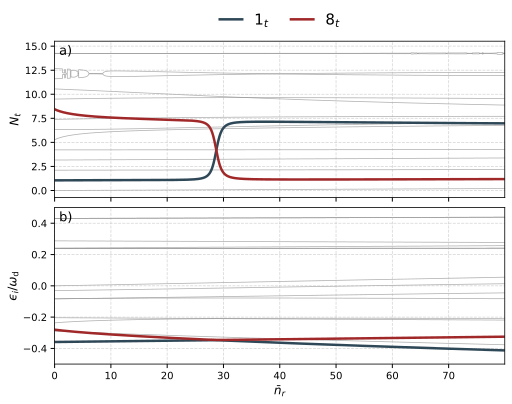

delta -2.397735819392353
n_r_critical (np.float64(27.90757687382513), np.float64(0.002640690443707905))


In [4]:
# Define parameters for the Floquet simulation
Ec = EC_fitted * 2 * np.pi
EjEc = EJ_fitted / EC_fitted
N = int(np.sqrt(8 * EjEc) / 2)  # Charge basis truncation
w_d = 6 * 2 * np.pi  # GHz (Drive frequency)
kappa = kappa_div2pi * 2 * np.pi

g_strength_sim = g_fitted * 2 * np.pi  # Coupling strength in GHz


# Define the range of resonator photon numbers using the for accuracy et_step ≈ kappa
def n_r_list_generation(n_r_max):
    et_step = kappa
    et_max = 2 * g_strength_sim * np.sqrt(n_r_max)
    et_list = np.arange(0, et_max, et_step)
    n_r_list_sim = (et_list / (2 * g_strength_sim)) ** 2
    return n_r_list_sim


n_r_max_val = 80
n_r_list = n_r_list_generation(n_r_max_val)

# n_r_list_sim = np.linspace(0, 100, 10001)

# Initialize the simulator
simulator = TransmonFloquetSimulator(Ec, EjEc, N, w_d, g_strength_sim, n_r_list, ng=0, images_dir_path=images_dir_path)

result = simulator.find_n_r_critical(branch_index=1, branches_to_plot=[1, 8], plot=True)
state_energy = simulator.bare_eigenenergies[2] - simulator.bare_eigenenergies[1]
print("delta", (state_energy - w_d) / (2 * np.pi))
print("n_r_critical", result)

# Calculate $n_c(\Delta)$ for state 0 and 1

In [9]:
ng = np.linspace(0, 0.5, 25)
w_d = np.linspace(3.5, 9.5, 150) * 2 * np.pi

n_r_max_val = 2000
n_r_list = n_r_list_generation(n_r_max_val)

state_to_inspect = 1


def func_to_parallelize(ng_val, w_d_val):
    simulator_tmp = TransmonFloquetSimulator(Ec, EjEc, N, w_d_val, g_strength_sim, n_r_list, ng_val,
                                             images_dir_path=images_dir_path)

    n_critical_for_this_ng, energy_gap = simulator_tmp.find_n_r_critical(state_to_inspect, plot=False)
    state_energy = simulator_tmp.bare_eigenenergies[state_to_inspect + 1] - simulator_tmp.bare_eigenenergies[
        state_to_inspect]
    return n_critical_for_this_ng, (state_energy - w_d_val) / (2 * np.pi), ng_val, energy_gap


all_results = []
all_filtered_results = []
result_min = []
result_max = []
result_mean = []
result_ng0 = []
for w_d_val in tqdm(w_d, desc="Finding n_r_critical for different n_g and resonator frequencies"):
    result = Parallel(n_jobs=-1)(
        delayed(func_to_parallelize)(ng_val, w_d_val)
        for ng_val in ng
    )
    # remove nans
    result_filtered = [sublist for sublist in result if not any(np.isnan(item) for item in sublist)]

    all_results.append(result)
    all_filtered_results.append(result_filtered)
    if result_filtered:
        result_ng0 += [result_filtered[0]]
        result_min += [min(result_filtered, key=lambda x: x[0])]
        result_max += [max(result_filtered, key=lambda x: x[0])]
        result_mean += [np.mean(np.array(result_filtered)[:, 0])]

result_min = np.array(result_min)
result_max = np.array(result_max)
result_ng0 = np.array(result_ng0)
result_mean = np.array(result_mean)

time_string = time.strftime("%Y%m%d-%H%M%S")
filename = f"n_critical_wd-{min(w_d) / (2 * np.pi):.2f}-{max(w_d) / (2 * np.pi):.2f}-{len(w_d)}_n_r-{n_r_max_val}_state_{state_to_inspect}_{time_string}.npy"

with open(filename, "wb") as f:
    np.save(f, result_min)
    np.save(f, result_max)
    np.save(f, result_ng0)
    np.save(f, result_mean)
    np.save(f, all_results)

n_critical_min = result_min[:, 0]
n_critical_max = result_max[:, 0]
n_critical_ng0 = result_ng0[:, 0]
n_critical_mean = result_mean
delta_ng0 = result_ng0[:, 1]

Finding n_r_critical for different n_g and resonator frequencies: 100%|██████████| 150/150 [10:10:54<00:00, 244.36s/it] 


# Plot $n_c(\Delta)$ for state 0 and 1

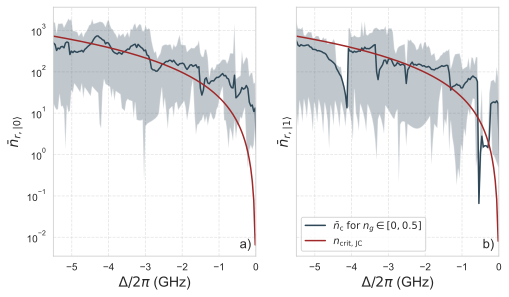

In [9]:
filename_state_1 = "n_critical_wd-3.5-9.5-150_n_r-2000_state_1_20250901-023939.npy"
filename_state_0 = "n_critical_wd-3.5-9.5-150_n_r-2000_state_0_20250901-140811.npy"

fig, axs = plt.subplots(1, 2, figsize=(8, 4.5), sharex=True, sharey=True)
axs_state_0 = axs[0]
axs_state_1 = axs[1]


def plot_results(ax, state_filename, state):
    with open(os.path.join(data_dir_path, state_filename), "rb") as file:
        result_min_loaded = np.load(file)
        result_max_loaded = np.load(file)
        result_ng0_loaded = np.load(file)
        result_mean_loaded = np.load(file)
        all_results_loaded = np.load(file)

    ax.set_xlabel(r'$\Delta/2\pi$ (GHz)')

    ax.set_ylabel(r'$\bar{n}_{r, |0\rangle}$' if state == 0 else r'$\bar{n}_{r, |1\rangle}$')
    ax.set_yscale("log")

    deltas_x_axis = result_min_loaded[:, 1]

    ax.plot(deltas_x_axis, result_mean_loaded, label=r"$\bar{n}_\text{c} \; \text{for} \; n_g\in[0, 0.5]$")
    ax.fill_between(deltas_x_axis, result_min_loaded[:, 0], result_max_loaded[:, 0], alpha=0.3)

    ax.plot(deltas_x_axis, deltas_x_axis ** 2 / (4 * g_fitted ** 2), c="C1", label = r"$n_{\text{crit, JC}}$")

    ax.text(0.92, 0.07, "a)" if state == 0 else "b)", transform=ax.transAxes, va='top', ha='left', fontsize=13)
    ax.set_xlim([-5.5, 0])


plot_results(axs_state_0, filename_state_0, 0)
plot_results(axs_state_1, filename_state_1, 1)

plt.legend()
file_path_no_type = os.path.join(images_dir_path, "detuning_nc_with_ng")
plt.savefig(file_path_no_type+".png", bbox_inches='tight')
plt.savefig(file_path_no_type+".pdf", bbox_inches='tight')
plt.show()

# Plot $n_c(\Delta)$ for state 1 with probabilities

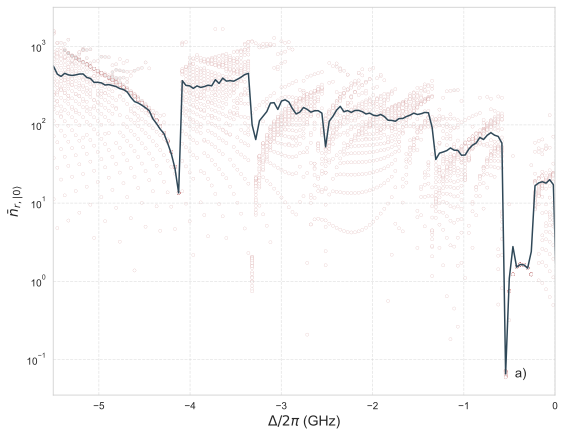

In [71]:
filename_state_0 = "n_critical_wd-3.50-9.50-150_n_r-2000_state_1_20250906-084236_with _energy_gaps.npy"

fig, axs = plt.subplots(1, 1, figsize=(9, 7))
axs_state_0 = axs


def plot_results(ax, state_filename, state):
    with open(os.path.join(data_dir_path, state_filename), "rb") as file:
        result_min_loaded = np.load(file)
        result_max_loaded = np.load(file)
        result_ng0_loaded = np.load(file)
        result_mean_loaded = np.load(file)
        all_results_loaded = np.load(file)
    #
    # energy_gaps = result_min[:, 2]
    # energy_gaps_normalised = 1 - (energy_gaps / max(energy_gaps[energy_gaps > 0]))
    # energy_gaps_colors = [(float(x), float(x), float(x)) for x in energy_gaps_normalised]

    ax.set_xlabel(r'$\Delta/2\pi$ (GHz)')

    ax.set_ylabel(r'$\bar{n}_{r, |0\rangle}$' if state == 0 else r'$\bar{n}_{r, |1\rangle}$')
    ax.set_yscale("log")

    # ax.scatter(result_min_loaded[:, 1], result_min_loaded[:, 0], label=r"$\bar{n}_\text{c, min} \; \text{for} \; n_g\in[0, 0.5]$",
    #         c=energy_gaps_colors, s = 10, zorder=20)

    for ng_index in range(all_results_loaded.shape[1]):
        results_for_ng = all_results_loaded[:, ng_index]
        energy_gaps = results_for_ng[:, 3]

        if not energy_gaps[energy_gaps > 0].size:
            continue
        # energy_gaps_normalised = 1 - (energy_gaps / max(energy_gaps[energy_gaps > 0]))
        test_probabilities = np.exp(- np.pi * np.abs(energy_gaps) ** 2)
        energy_gaps_colors = [(float(x), float(x), float(x)) for x in test_probabilities]

        # ax.plot(results_for_ng[:, 1], results_for_ng[:, 0], alpha = 0.5, color='C1')

        ax.scatter(results_for_ng[:, 1], results_for_ng[:, 0], alpha=0.9,
                   c=energy_gaps_colors, s=10, linewidths=0.1, edgecolors="C1", zorder=-20)

    ax.plot(result_min_loaded[:, 1], result_mean_loaded, label=r"$\bar{n}_\text{c} \; \text{for} \; n_g\in[0, 0.5]$")
    # ax.fill_between(result_min_loaded[:, 1], result_min_loaded[:, 0], result_max_loaded[:, 0], alpha=0.3)

    ax.text(0.92, 0.07, "a)" if state == 0 else "b)", transform=ax.transAxes, va='top', ha='left', fontsize=13)
    ax.set_xlim([-5.5, 0])


plot_results(axs_state_0, filename_state_0, 0)

plt.savefig("detuning_nc_with_ng_with_prob.png", bbox_inches='tight')
plt.savefig("detuning_nc_with_ng_with_prob.pdf", bbox_inches='tight')
plt.show()

In [53]:
np.array(all_results)[:, 1]

array([[ 1.82655106e-01,  1.02266138e-01,  2.08333333e-02,
         5.37250290e-03],
       [ 3.60598231e-01,  6.19976821e-02,  2.08333333e-02,
         4.32071951e-02],
       [ 4.68337233e-01,  2.17292257e-02,  2.08333333e-02,
         5.18004670e-02],
       [ 3.20214507e+01, -1.85392307e-02,  2.08333333e-02,
         2.12560341e-02],
       [ 5.12268112e+01, -5.88076871e-02,  2.08333333e-02,
         5.68653498e-03],
       [ 2.41561378e+01, -9.90761434e-02,  2.08333333e-02,
         1.31762297e-03],
       [ 2.26643349e+01, -1.39344600e-01,  2.08333333e-02,
         1.28230541e-03],
       [ 2.10459890e+01, -1.79613056e-01,  2.08333333e-02,
         1.18574316e-03],
       [ 1.92494951e+01, -2.19881513e-01,  2.08333333e-02,
         1.07488539e-03],
       [ 1.22395164e+00, -2.60149969e-01,  2.08333333e-02,
         1.77229251e-02],
       [ 1.47506217e+00, -3.00418425e-01,  2.08333333e-02,
         2.22032947e-03],
       [ 1.62315299e+00, -3.40686882e-01,  2.08333333e-02,
      